# ONDE ACUSTICHE DOTATE DI MOMENTO ANGOLARE ORBITALE

##### LIBRERIE, ESTETICA E DEFAULT

In [1]:
import csv
import math
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
import random
from scipy.special import genlaguerre
from scipy.optimize import least_squares
from tabulate import tabulate

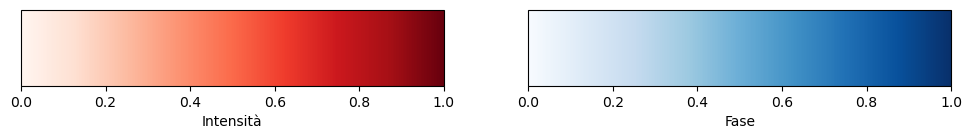

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(12, 2))
fig.subplots_adjust(bottom=0.5)

sm1 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=1))
sm1.set_array([])
axs[0].grid(False)
cbar1 = fig.colorbar(sm1, cax=axs[0], orientation='horizontal')
cbar1.set_label('Intensità')

sm2 = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=1))
sm2.set_array([])
axs[1].grid(False)
cbar2 = fig.colorbar(sm2, cax=axs[1], orientation='horizontal')
cbar2.set_label('Fase')

plt.savefig('images/colorbars.png', format='png', dpi=300)
plt.show()

In [3]:
a = 0.5
x = np.linspace(-a, a, 1000)
y = np.linspace(-a, a, 1000)
X, Y = np.meshgrid(x, y)
extent = (-a, a, -a, a)

z0 = 0.2
z0_values = [0.005, 0.045, 0.1]

In [4]:
# GRAFICI INTENSITA' E FASE 2D
def duo_plot(W, filename):
	
	folder = "images"
	if not os.path.exists(folder):
		os.makedirs(folder)

	filepath = os.path.join(folder, filename)
	
	fig, axs = plt.subplots(1, 2, figsize=(6, 4))
    
	contour_intensity = axs[0].imshow(np.abs(W)**2, extent=extent, cmap='Reds', origin='lower')
	axs[0].set_title(f'Intensità')
	axs[0].set_xlabel('x (m)')
	axs[0].set_ylabel('y (m)')
	axs[0].axhline(0, color='black', linewidth=0.5)
	axs[0].axvline(0, color='black', linewidth=0.5)
	
	contour_phase = axs[1].imshow(np.angle(W), extent=extent, cmap='Blues', origin='lower')
	axs[1].set_title(f'Fase')
	axs[1].set_xlabel('x (m)')
	axs[1].set_ylabel('y (m)')
	axs[1].axhline(0, color='black', linewidth=0.5)
	axs[1].axvline(0, color='black', linewidth=0.5)

	plt.tight_layout()
	plt.savefig(filepath, format='png', dpi=300)
	plt.show()

## MODELLO LAGUERRE-GAUSS

$ U (r,\theta,z) = A\sqrt{\frac{2p!}{\pi w^2(p+|\ell|)!}}\left(\frac{r\sqrt{2}}{w}\right)^{|\ell|} \cdot \exp\left(-\frac{r^2}{w^2}\right) \cdot L_p^l(\frac{2r^2}{w^2})\exp(-i\ell\theta) \cdot exp\left(\frac{ikr^2z}{2(z^2+z_r^2)}\right) \cdot \exp\left(\frac{-i(2p+|\ell|+1)}{\tan{\frac{z}{z_r}}}\right) \cdot \exp(i\phi) $

- $ r, \theta, z $: Coordinate cilindriche
- $ \lambda $: Lunghezza d'onda
- $ k $: Numero d'onda
- $ A $: Normalizzazione
- $ p $: Numero radiale
- $ \ell $: Numero angolare (Carica topologica)
- $ z_r = \pi \frac{ w_0}{\lambda} $: Distanza di Rayleigh
- $ w_0 $: Larghezza del fascio
- $ w = w_0 \sqrt{1 + (\frac{z}{zr}) ^ 2}$
- $ L_p^l( \frac{2r^2}{w^2}) $: Polinomi di Laguerre generalizzati
- $ i $ Unità immaginaria
- $ \phi $: Costante di fase

In [5]:
# FASCI LG PURI
def LG_pl(x=X, y=Y, z=z0, A=1, w0=0.01, lam=0.57, p=0, l=1, ph=0, c=True):
	r = np.hypot(x, y)
	theta = np.arctan2(y, x)
	
	k = 2*np.pi/lam
	zr = np.pi*w0**2/lam
	w = w0*np.sqrt(1+(z/zr)**2)
	L_p_l = genlaguerre(p, np.abs(l))(2 * r**2 / w**2)
		
	norm = A * np.sqrt((2*math.factorial(p))/(np.pi*w**2*math.factorial(p+np.abs(l))))*(r*np.sqrt(2)/w)**np.abs(l)
	gauss = np.exp(-r**2/w**2)
	lag = L_p_l * np.exp(1j*l*theta)
	curv = np.exp(1j*k*r**2*z/2/(z**2+zr**2))
	if c == False:
		curv = 1
	guoy = np.exp(-1j*(2*p+np.abs(l)+1)/np.tan(z/zr))
	arb = np.exp(1j*ph)
	
	return  norm * gauss * lag * curv * guoy * arb

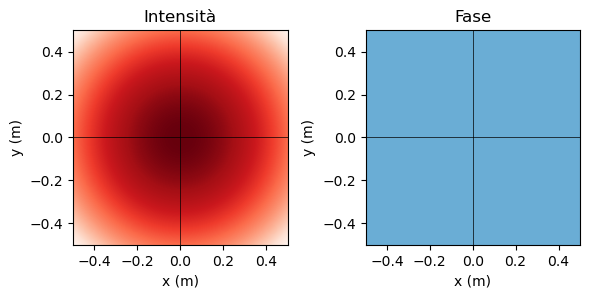

In [6]:
# Fascio Gaussiano: l=0 
LG = LG_pl(l=0, ph=0.5, c=False)
duo_plot(LG, 'LG0.png')

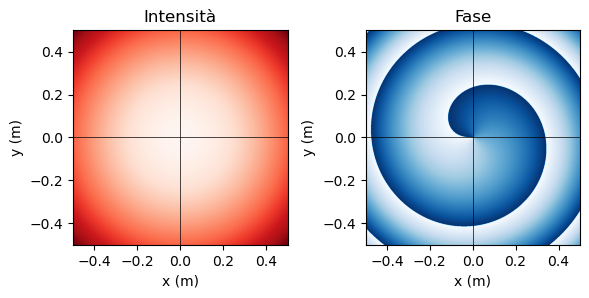

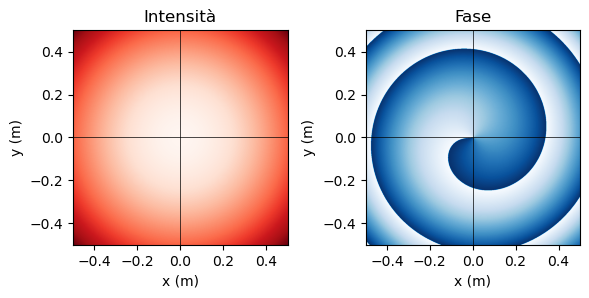

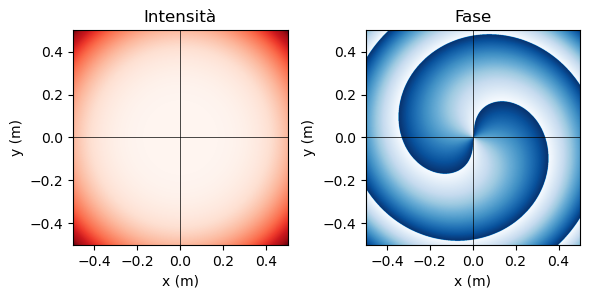

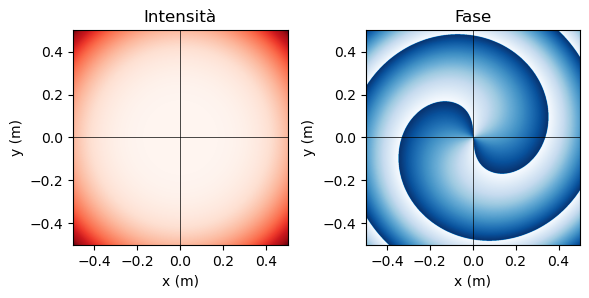

In [7]:
# Fasci l=1,2
for l in [1, -1, 2, -2]:
	LG = LG_pl(l=l)
	duo_plot(LG, f'LG{l}.png')

In [8]:
# FASCI LG COME SOVRAPPOSIZIONE DI 8 GAUSSIANI
def LG_sum(x=X, y=Y, z=z0, A=1, A_err=0, w0=0.03, lam=0.57, p=0, l=1, ph=0, phi_err=0, d=0.013, c=True):
	angles = np.linspace(0 + np.pi / 8 + ph, 2 * np.pi + np.pi / 8 + ph, 8, endpoint=False)
	vert = [(d * np.cos(angle), d * np.sin(angle)) for angle in angles]
		
	LG = np.zeros_like(x, dtype = complex)
	for i in range(8):
		A = A*random.uniform(1-A_err/2, 1+A_err/2)
		phi = i*l*np.pi/4*random.uniform(np.sqrt(1-phi_err/2), np.sqrt(1+phi_err/2))
		LG += LG_pl(x+vert[i][0], y+vert[i][1], z=z, A=A, w0=w0, lam=lam, p=p, l=0, ph=phi, c=c)
		
	return LG

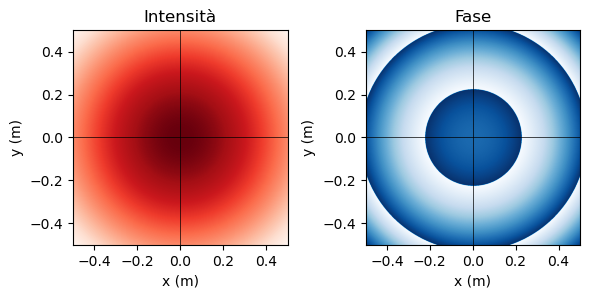

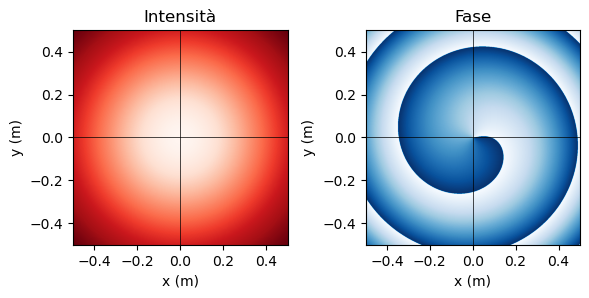

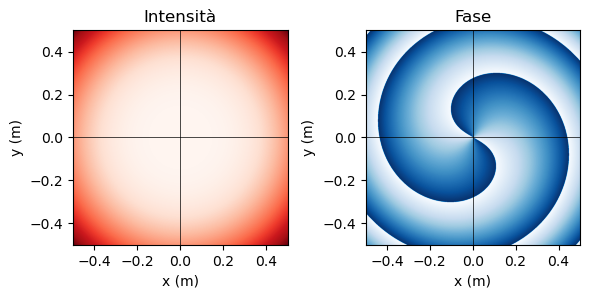

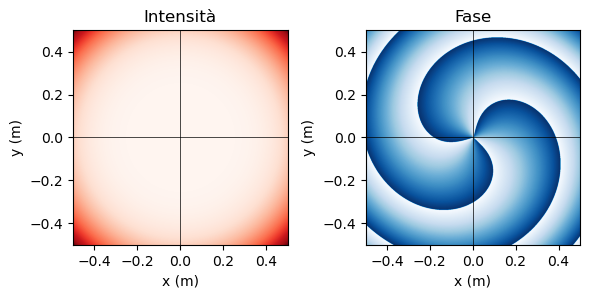

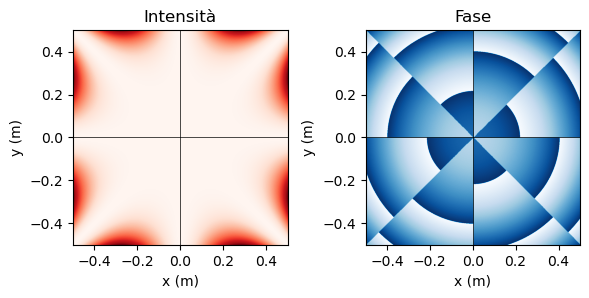

In [9]:
# Vortici l=0-4
for l in range(5):
	LG=LG_sum(l=l)
	duo_plot(LG, f'LG{l}_sum.png')

#### DEVIAZIONI CASUALI

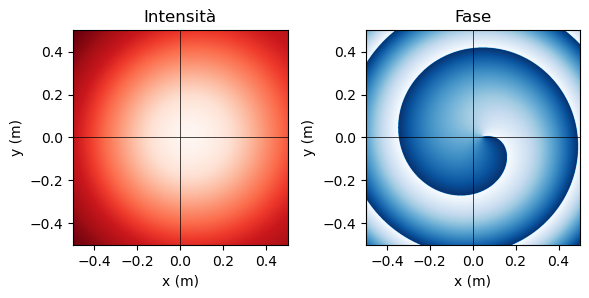

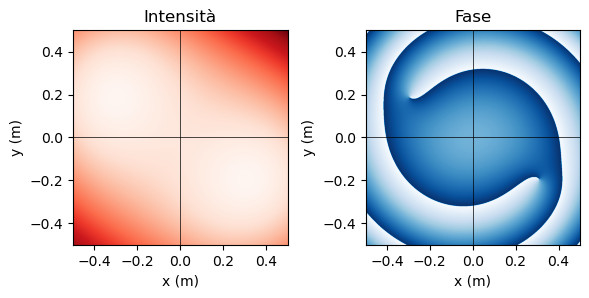

In [10]:
# Sorgenti non omogenee in intensità
for l in [1,2]:
	LG=LG_sum(A_err=0.05,l=l)
	duo_plot(LG, f'LG{l}_amperr.png')

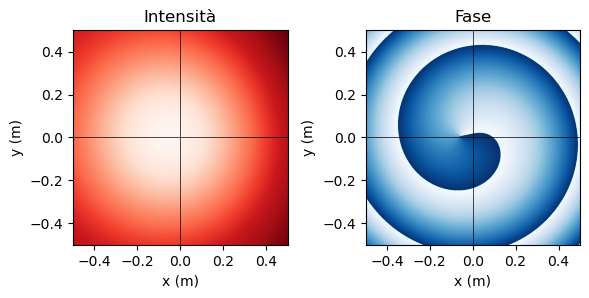

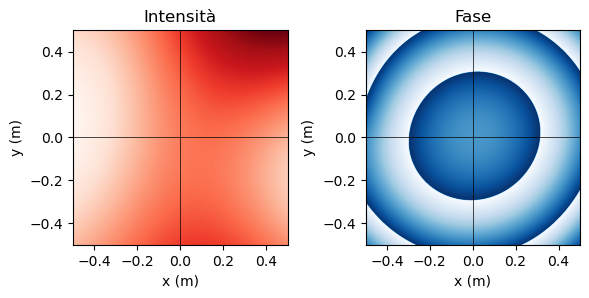

In [11]:
# Sorgenti con sfasamenti non omogenei
for l in [1,2]:
	LG=LG_sum(phi_err=0.087,l=l)
	duo_plot(LG, f'LG{l}_pherr.png')

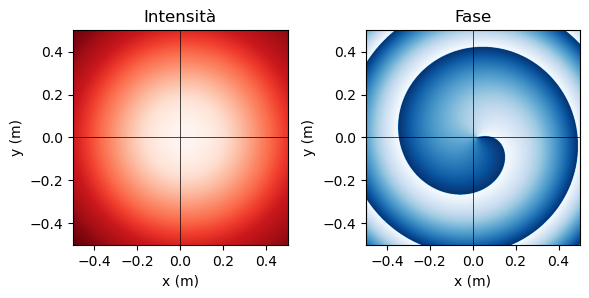

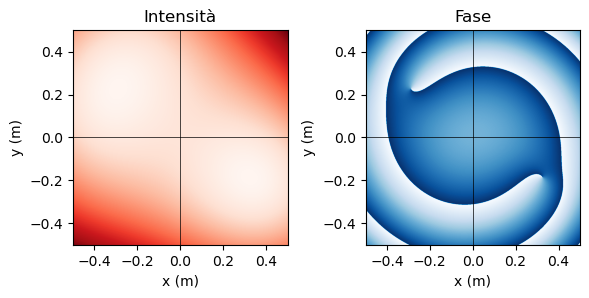

In [12]:
# Sorgenti eterogenee
for l in [1,2]:
	LG=LG_sum(A_err=0.025,phi_err=0.025,l=l)
	duo_plot(LG, f'LG{l}_err.png')

## SETUP SPERIMENTALE

L'apparato è stato progettato a partire dal dispositivo documentato in "A compact acoustic spanner to rotate macroscopic objects" https://doi.org/10.5525/gla.researchdata.628)

<img src="images/tutto_34.jpg" alt="Alt text" width="600" height="400">

### Codice Arduino

<img src="images/arduino.jpg" alt="Alt text" width="600" height="400">

```c++
// Codice per Arduino Mega 2560
// Generatore di OAMW

// Inizializzazione
    #define SPK_PIN1 12
    #define SPK_PIN2 11
    #define SPK_PIN3 10
    #define SPK_PIN4 9
    #define SPK_PIN5 8
    #define SPK_PIN6 7
    #define SPK_PIN7 6
    #define SPK_PIN8 5
    #define LED_PIN1 44
    #define LED_PIN2 45
    #define LED_PIN3 46
    #define AMP_PIN 14
    
    // Numero campioni
    const unsigned int smp = 96;
    // Tabelle d'onda definite su due periodi
    int Sin1[2*smp];
    int Sin2[2*smp];
    int Sin3[2*smp];
    int Sin4[2*smp];
    int Sin5[2*smp];
    int Sin6[2*smp];
    int Sin7[2*smp];
    int Sin8[2*smp];
    // Inizializzazione variabili: correzioni di fase
    unsigned int inc;
    int p2 = 0;
    int p3 = 0;
    int p4 = 0;
    int p5 = 0;
    int p6 = 0;
    int p7 = 0;
    int p8 = 0;
    unsigned int t = 0;

// Setup
    void setup() {
    // Impostazioni dei clock interni
        TCCR3B = TCCR3B & B11111000 | B00000001; // 2 3 5
        TCCR4B = TCCR4B & B11111000 | B00000001; // 6 7 8 
        TCCR2B = TCCR2B & B11111000 | B00000001; // 9 10
        TCCR5B = TCCR5B & B11111000 | B00000001; // 44 45 46
        TCCR1B = TCCR1B & B11111000 | B00000001; // 11 12
    // Impostazioni dei pin       
        pinMode(SPK_PIN1, OUTPUT);
        pinMode(SPK_PIN2, OUTPUT);
        pinMode(SPK_PIN3, OUTPUT);
        pinMode(SPK_PIN4, OUTPUT);
        pinMode(SPK_PIN5, OUTPUT);
        pinMode(SPK_PIN6, OUTPUT);
        pinMode(SPK_PIN7, OUTPUT);
        pinMode(SPK_PIN8, OUTPUT);
        pinMode(LED_PIN1, OUTPUT);
        digitalWrite(LED_PIN1,LOW);
        pinMode(LED_PIN2, OUTPUT);
        digitalWrite(LED_PIN2, LOW);
        pinMode(LED_PIN3, OUTPUT);
        digitalWrite(LED_PIN3, LOW);
        pinMode(AMP_PIN, OUTPUT);
        digitalWrite(AMP_PIN, HIGH);
        
    // Setup OAMW
/*  // l = 0
        inc = 0;
        digitalWrite(LED_PIN2, HIGH); */
    // l = 1
        inc = smp/8/5;
        digitalWrite(LED_PIN3, HIGH);
        \\ Correzioni
        p2=-1;
        p3=2;
        p4=1;
        p5=1;
        p6=2;
        p7=5;
        p8=3;
/*  // l = 2
        inc = smp/4/5;
        digitalWrite(LED_PIN3, HIGH); */
    // Tabelle d'onda
        for(int i=0; i<2*smp; i++){
            Sin1[i]=31*(sin(5*2*PI/smp*(i+0*inc))+1)/2;
            Sin2[i]=38*(-sin(5*2*PI/smp*(i+1*inc+p2))+1)/2;
            Sin3[i]=40*(-sin(5*2*PI/smp*(i+2*inc+p3))+1)/2;
            Sin4[i]=30*(sin(5*2*PI/smp*(i+3*inc+p4))+1)/2;
            Sin5[i]=46*(-sin(5*2*PI/smp*(i+4*inc+p5))+1)/2;
            Sin6[i]=29*(sin(5*2*PI/smp*(i+5*inc+p6))+1)/2;
            Sin7[i]=20*(-sin(5*2*PI/smp*(i+6*inc+p7))+1)/2;
            Sin8[i]=28*(sin(5*2*PI/smp*(i+7*inc+p8))+1)/2;
        }
    }

// Ciclo di lavoro
    void loop() {
        int i=t-smp*(int)(t/smp);       // Indice ciclico
        analogWrite(SPK_PIN1, Sin1[i]);
        analogWrite(SPK_PIN2, Sin2[i]); // Canale invertito
        analogWrite(SPK_PIN3, Sin3[i]); // Canale invertito
        analogWrite(SPK_PIN4, Sin4[i]);
        analogWrite(SPK_PIN5, Sin5[i]); // Canale invertito
        analogWrite(SPK_PIN6, Sin6[i]);
        analogWrite(SPK_PIN7, Sin7[i]); // Canale invertito
        analogWrite(SPK_PIN8, Sin8[i]);     
        t++;
    }
```

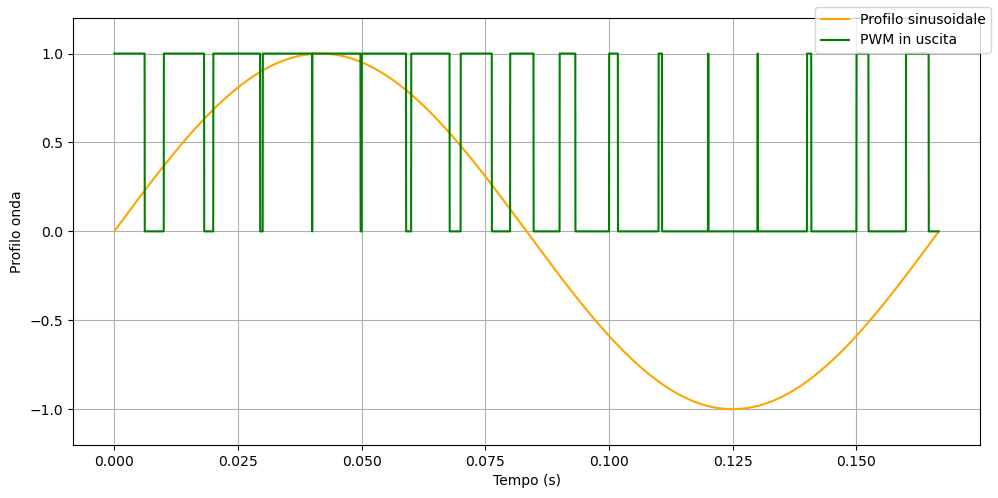

In [13]:
# Algoritmo DDS
sine_frequency = 6    # Frequenza segnale sinusoidale (Hz)
amplitude = 1         # Ampiezza segnale sinusoidale
phase = 0             # Costante di fase 
sampling_rate = 1000  # Rate campionamento (sample/s)

t_sine = np.linspace(0, 1/sine_frequency, int(sampling_rate), endpoint=False)
sine_wave = amplitude * np.sin(2 * np.pi * sine_frequency * t_sine + phase)


pulse_frequency = 100                          # Frequenza PWM (Hz)
duration_pulse = 1 / pulse_frequency           # Periodo
sampling_rate_pulse = sampling_rate * 1000     # Campionamento * 1000

t_pulse = np.linspace(0, 1/sine_frequency, int(duration_pulse * sampling_rate_pulse), endpoint=False)
duty_cycle_pulse = 0.5 + 0.5 * np.sin(2 * np.pi * sine_frequency * t_pulse + phase)
pulse_wave = np.where(t_pulse % duration_pulse < duty_cycle_pulse * duration_pulse, 1, 0)

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Profilo onda')
ax.plot(t_sine, sine_wave, color='orange', label='Profilo sinusoidale')
ax.set_ylim(-1.2, 1.2)

ax.plot(t_pulse, pulse_wave, color='green', label='PWM in uscita')

fig.tight_layout()
fig.legend()
plt.grid(True)
plt.savefig('images/dds.png', format='png', dpi=300)
plt.show()

### CIRCUITO

#### SCHEMA

<img src="images/Schematics.png" alt="Alt text" width="1000" height="800">

<img src="images/circuit.jpg" alt="Alt text" width="600" height="400">

#### RISPOSTA IN FREQUENZA DEI FILTRI

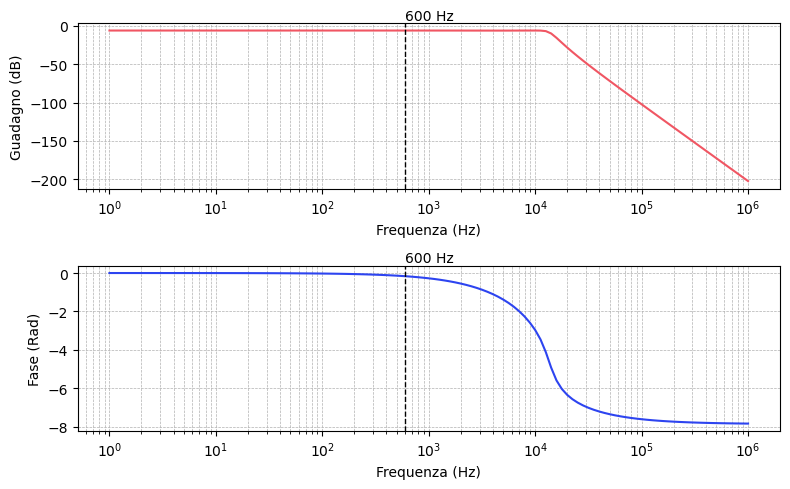

In [14]:
# Risposta in frequenza Tchebyschev
freq = pd.read_csv('data/freq.csv')

frequency = freq['FREQUENCY']
magnitude = freq['MAGNITUDE']
phase = freq['PHASE']

fig, ax1 = plt.subplots(2, 1, figsize=(8, 5))

ax1[0].semilogx(frequency, 20 * np.log10(magnitude), color='#f05663')
ax1[0].grid(True, which='both', linestyle='--', linewidth=0.5)
ax1[0].axvline(x=600, color='black', linestyle='--', linewidth=1)
ax1[0].text(600, ax1[0].get_ylim()[1], '600 Hz', color='black', verticalalignment='bottom')

ax1[1].semilogx(frequency, np.unwrap(phase), color='#2d44f0')
ax1[1].grid(True, which='both', linestyle='--', linewidth=0.5)
ax1[1].axvline(x=600, color='black', linestyle='--', linewidth=1)
ax1[1].text(600, ax1[1].get_ylim()[1], '600 Hz', color='black', verticalalignment='bottom')

ax1[0].set_xlabel('Frequenza (Hz)')
ax1[0].set_ylabel('Guadagno (dB)')
ax1[1].set_xlabel('Frequenza (Hz)')
ax1[1].set_ylabel('Fase (Rad)')

plt.tight_layout()
plt.savefig('images/lowpass.png', format='png', dpi=300)
plt.show()

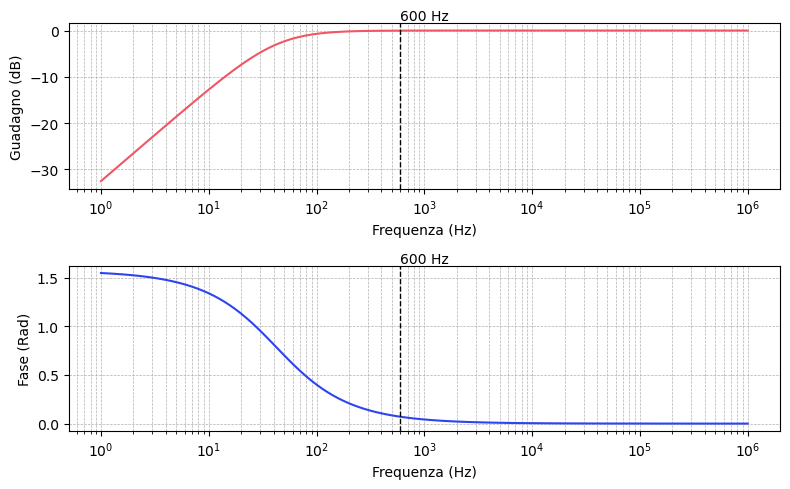

In [15]:
# Risposta in frequenza RC
freq = pd.read_csv('data/freqHP.csv')

frequency = freq['FREQUENCY']
magnitude = freq['MAGNITUDE']
phase = freq['PHASE']

fig, ax1 = plt.subplots(2, 1, figsize=(8, 5))

ax1[0].semilogx(frequency, 20 * np.log10(magnitude), color='#f05663')
ax1[0].grid(True, which='both', linestyle='--', linewidth=0.5)
ax1[0].axvline(x=600, color='black', linestyle='--', linewidth=1)
ax1[0].text(600, ax1[0].get_ylim()[1], '600 Hz', color='black', verticalalignment='bottom')

ax1[1].semilogx(frequency, np.unwrap(phase), color='#2d44f0')
ax1[1].grid(True, which='both', linestyle='--', linewidth=0.5)
ax1[1].axvline(x=600, color='black', linestyle='--', linewidth=1)
ax1[1].text(600, ax1[1].get_ylim()[1], '600 Hz', color='black', verticalalignment='bottom')


ax1[0].set_xlabel('Frequenza (Hz)')
ax1[0].set_ylabel('Guadagno (dB)')
ax1[1].set_xlabel('Frequenza (Hz)')
ax1[1].set_ylabel('Fase (Rad)')

plt.tight_layout()
plt.savefig('images/highpass.png', format='png', dpi=300)
plt.show()

### CALIBRAZIONE

In [16]:
# Calibrazione apparato
df = pd.read_excel('data/CALIBRAZIONE.xlsx', sheet_name='correzioni')

display(df)

,V [mV],AVG_DEV [%],AMPLITUDE_CORR,V_UPDT[mV],AVG_DEV [%].1,PH_TEO [RAD],dT[us],PH_FILT [RAD],ERR [RAD],dT_UPDT[us],PH_OUT [RAD],ERR[RAD],PH_CORR,dT_UPDT[us].1,PH_OUT_CORR [RAD],TEO_DEV [RAD]
0,790,-0.019090,1.0,815,0.002152,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,0.000000,0.000000
1,849,0.054167,8.0,800,-0.016293,0.785398,210,0.804876,-0.019478,300,1.149823,-0.364425,-1,200,0.766549,0.018850
2,706,-0.123390,10.0,848,0.042730,1.570796,360,1.379787,0.191009,250,0.958186,0.612611,2,400,1.533097,0.037699
3,810,0.005743,NaN,823,0.011989,2.356194,500,1.916372,0.439823,510,1.954699,0.401496,1,610,2.337973,0.018221
4,523,-0.350613,16.0,805,-0.010144,3.141593,690,2.644593,0.497000,680,2.606265,0.535327,1,810,3.104522,0.037071
5,835,0.036784,-1.0,810,-0.003996,3.926991,840,3.219504,0.707487,810,3.104522,0.822469,2,1020,3.909398,0.017593
6,1060,0.316157,-10.0,812,-0.001537,4.712389,990,3.794416,0.917973,840,3.219504,1.492885,5,1220,4.675947,0.036442
7,870,0.080242,-2.0,793,-0.024900,5.497787,1170,4.484309,1.013478,1150,4.407654,1.090133,3,1420,5.442495,0.055292


### RISPOSTA IN FREQUENZA MICROFONI

<img src="images/Behringer.png" alt="Alt text" width="600" height="400">

<img src="images/side.jpg" alt="Alt text" width="600" height="400">

### SOUNDCARD OSCILLOSCOPE

<img src="images/scope.jpg" alt="Alt text" width="400" height="300">

<img src="images/scope2.jpg" alt="Alt text" width="400" height="300">

## ESPERIMENTO, ANALISI DATI E CONFRONTO MODELLI

In [17]:
a = 0.07
x = np.linspace(-a, a, 1000)
y = np.linspace(-a, a, 1000)
X, Y = np.meshgrid(x, y)
extent = (-a, a, -a, a)

In [18]:
# GRAFICI INTENSITA' E FASE 2D (AGGIORNAMENTO DOMINIO)
def duo_plot(W, filename):
	
	folder = "images"
	if not os.path.exists(folder):
		os.makedirs(folder)

	filepath = os.path.join(folder, filename)
	
	fig, axs = plt.subplots(1, 2, figsize=(6, 4))
    
	contour_intensity = axs[0].imshow(np.abs(W)**2, extent=extent, cmap='Reds', origin='lower')
	axs[0].set_title(f'Intensità')
	axs[0].set_xlabel('x (m)')
	axs[0].set_ylabel('y (m)')
	axs[0].axhline(0, color='black', linewidth=0.5)
	axs[0].axvline(0, color='black', linewidth=0.5)

	contour_phase = axs[1].imshow(np.angle(W), extent=extent, cmap='Blues', origin='lower')
	axs[1].set_title(f'Fase')
	axs[1].set_xlabel('x (m)')
	axs[1].set_ylabel('y (m)')
	axs[1].axhline(0, color='black', linewidth=0.5)
	axs[1].axvline(0, color='black', linewidth=0.5)

	plt.tight_layout()
	plt.savefig(filepath, format='png', dpi=300)
	plt.show()

In [19]:
# MODELLO CON SORGENTI REALI
def LG_meas(x=X, y=Y, z=z0, A=1, w0=0.03, lam=0.57, p=0, l=1,  ph=0, d=0.013, c=True):
	angles = np.linspace(0 + np.pi / 8 + ph, 2 * np.pi + np.pi / 8 + ph, 8, endpoint=False)
	vert = [(d * np.cos(angle), d * np.sin(angle)) for angle in angles]
	
	ampl = np.array([-0.002, -0.025, 0.002, -0.016, 0.043, 0.012, -0.010, -0.004])
	pha = np.array([0.04, 0.06, 0, 0.02, 0.04, 0.02, 0.04, 0.02])
	
	LG = np.zeros_like(x, dtype = complex)
	for i in range(8):
		A=A*(1+ampl[i])
		phi=i*l*np.pi/4+pha[i]+ph
		LG += LG_pl(x+vert[i][0], y+vert[i][1], z=z, A=A, w0=w0, lam=lam, p=p, l=0, ph=phi, c=c)
		
	return LG

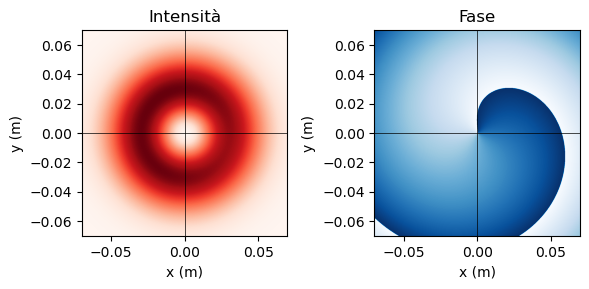

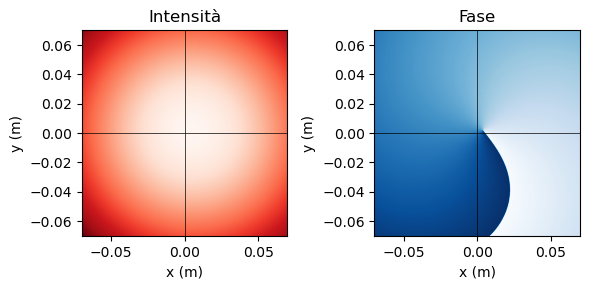

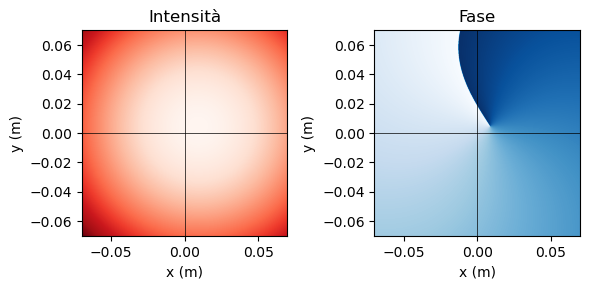

In [20]:
# Simulazione vortici alle distanze sperimentali
for z0 in z0_values:
	LG_exp = LG_meas(x=X, y=Y, z=z0)
	duo_plot(LG_exp, f'LG_exp{z0}.png')

In [21]:
# TRACCIAMENTO DELLA SINGOLARITÀ
def sngl(W):
	values = np.abs(W)**2
	min_index = np.unravel_index(np.argmin(values, axis=None), values.shape)
	min_value = values[min_index]
	return (X[min_index], Y[min_index])

def track(W):
	z0_lin = np.linspace(0.01,0.5,10)
	hypot_values = []
	min_points_x = []
	min_points_y = []

	for z0 in z0_lin:
		LG=W(x=X, y=Y, z=z0)
		min_point=sngl(LG)    
		hypot_values.append(np.hypot(min_point[0], min_point[1]))
		min_points_x.append(min_point[0])
		min_points_y.append(min_point[1])

	plt.figure(figsize=(8, 4))

	# SPOSTAMENTO
	plt.subplot(1, 2, 1)
	plt.scatter(z0_lin, hypot_values, marker='o', color='black')
	plt.xlabel("z (m)")
	plt.ylabel("Distanza singolarità - origine (m)")
	plt.ylim(0,0.06)
	plt.grid(True)
	coeffs = np.polyfit(z0_lin, hypot_values, 1)
	fit_line = np.polyval(coeffs, z0_lin)
	plt.plot(z0_lin, fit_line, color='green', linestyle='--', label='Linear fit')

	# POSIZIONE
	plt.subplot(1, 2, 2)
	plt.scatter(min_points_x, min_points_y, marker='o', color='black')
	plt.xlabel("x (m)")
	plt.ylabel("y (m)")
	plt.grid(True)
	coeffs = np.polyfit(min_points_x, min_points_y, 1)
	fit_line = np.polyval(coeffs, min_points_x)
	plt.plot(min_points_x, fit_line, color='green', linestyle='--', label='Linear fit')

	plt.subplots_adjust(wspace=0.6)
	plt.tight_layout()
	plt.savefig('images/displacement.png', format='png', dpi=300)
	plt.show()

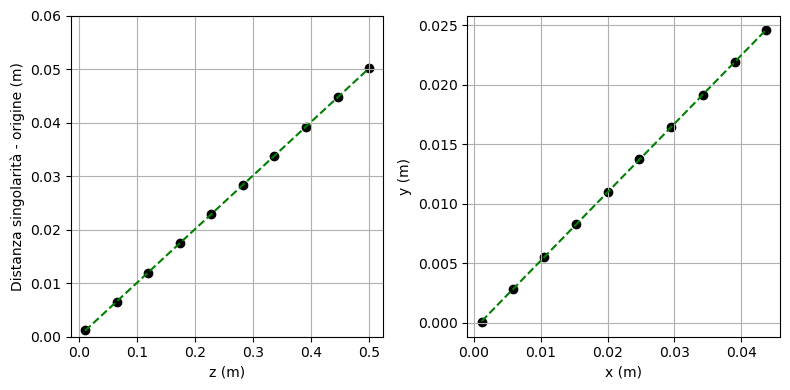

In [22]:
# Tracciamento singolarità per i tre modelli	
track(LG_meas)

In [23]:
# GRAFICI INTENSITA' E FASE, SCANSIONI ORIZZONTALI
def plot_hor(W, E, ax):
	ax[0].plot(X[0, :], (np.abs(W)**2), color='red')
	ax[0].plot(X[0, :], (np.abs(E)**2), color='red', linestyle='--')
	ax[0].set_xlabel('x (m)')
	ax[0].set_xlim(-a, a)
	ax[0].set_ylabel('Intensità')
	ax[0].grid(True)
	
	ax[1].plot(X[0, :], np.mod(np.angle(W),2*np.pi), color='blue')
	ax[1].plot(X[0, :], np.mod(np.angle(E),2*np.pi), color='blue', linestyle='--')
	ax[1].set_xlabel('x (m)')
	ax[1].set_xlim(-a, a)
	ax[1].set_ylabel('Fase (rad)')
	ax[1].grid(True)
	
fig_legend = plt.figure(figsize=(4, 2))
handles = []
labels = []
handles.append(plt.Line2D([0], [0], color='black', label='Modello completo'))
handles.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Laguerre-Gauss puro'))
labels = ['Modello completo', 'Laguerre-Gauss puro']
fig_legend.legend(handles=handles, labels=labels, loc='center')
plt.savefig('images/legend.png', format='png', dpi=300)

<Figure size 400x200 with 0 Axes>

In [24]:
# GRAFICI INTENSITA' E FASE, SCANSIONI ORIZZONTALI NORMALIZZATE
def plot_hor(W, E, ax):
	ars = [W, E]
	N = [(np.abs(ar)**2).max() for ar in ars]
	O = [(np.unwrap(np.angle(ar))).min() for ar in ars]
	
	ax[0].plot(X[0, :], (np.abs(W)**2)/N [0], color='red')
	ax[0].plot(X[0, :], (np.abs(E)**2)/N[1], color='red', linestyle='--')
	ax[0].set_xlabel('x (m)')
	ax[0].set_xlim(-a, a)
	ax[0].set_ylabel('Intensità')
	ax[0].grid(True)
	
	ax[1].plot(X[0, :], np.unwrap(np.angle(W))-O[0], color='blue')
	ax[1].plot(X[0, :], np.unwrap(np.angle(E))-O[1], color='blue', linestyle='--')
	ax[1].set_xlabel('x (m)')
	ax[1].set_xlim(-a, a)
	ax[1].set_ylim(-0.5,3.5)
	ax[1].set_ylabel('Fase (rad)')
	ax[1].grid(True)

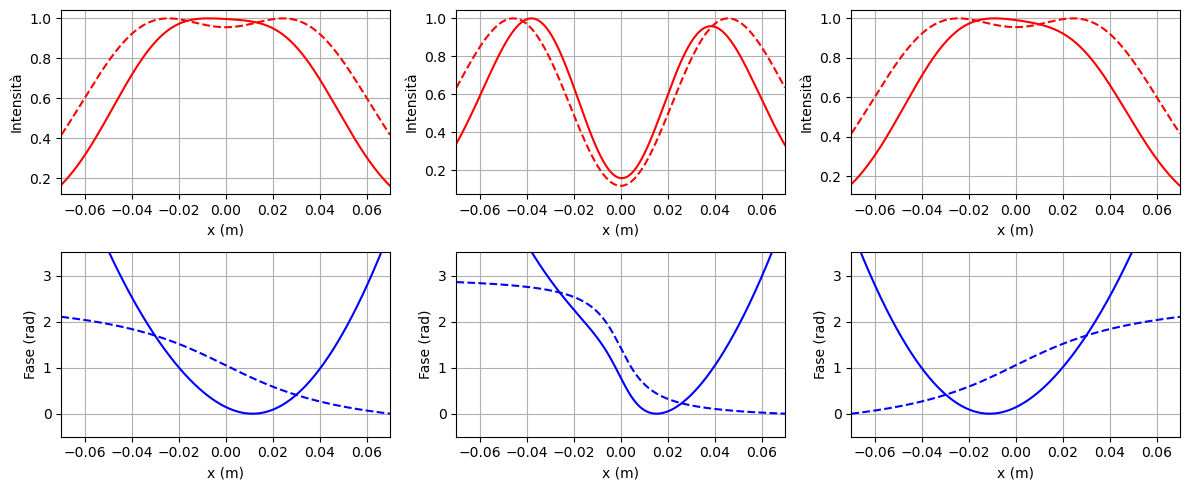

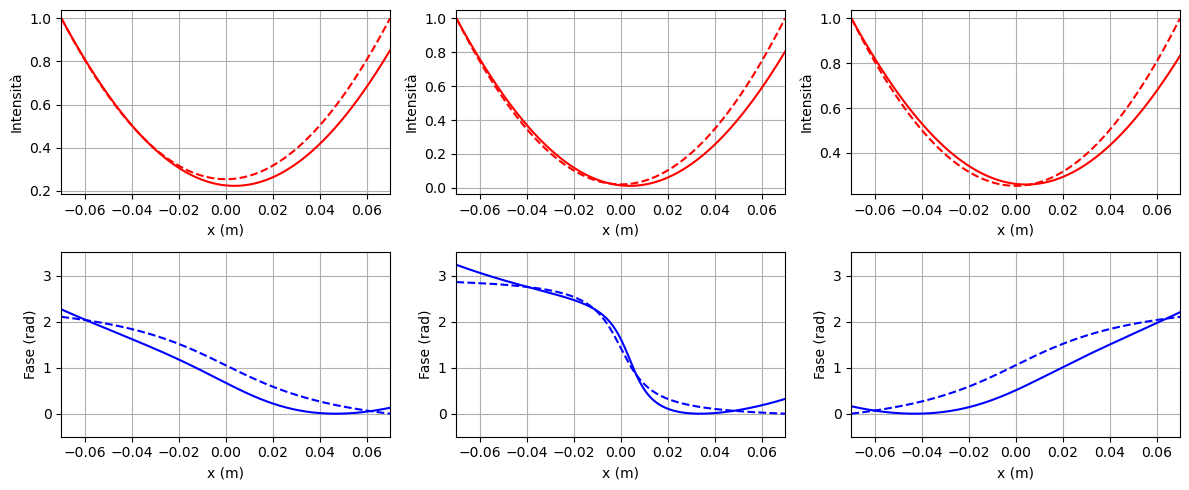

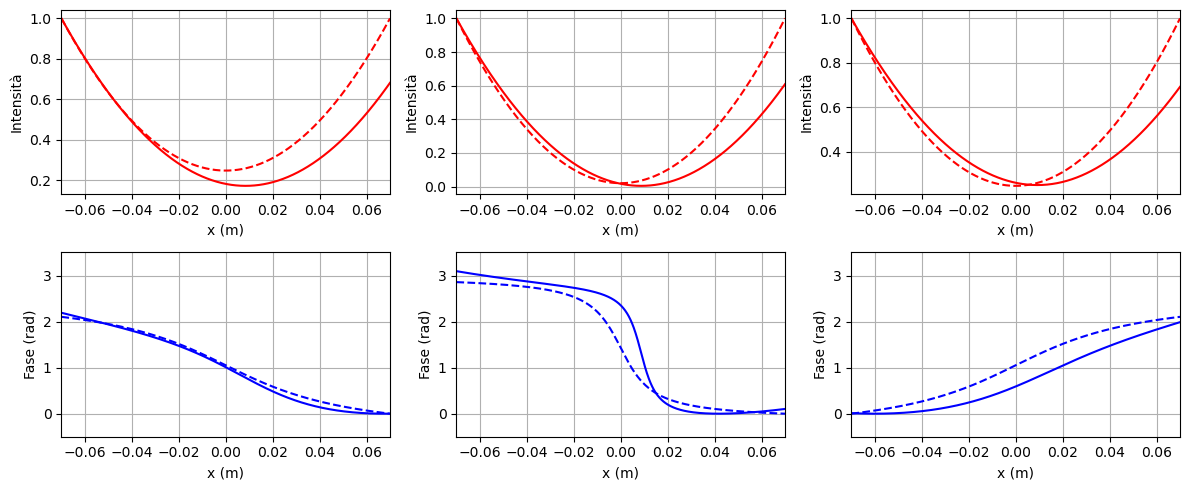

In [25]:
# Scansioni orizzontali alle distanze sperimentali
for z0 in [0.005, 0.045, 0.1]:
	LG_exp = LG_meas(x=X, y=Y, z=z0, w0=0.014)
	LG_pur = LG_pl(x=X, y=Y, z=z0, w0=0.014, c=False)
	
	fig, axs = plt.subplots(2, 3, figsize=(12, 5))
	
	for idx, y0 in enumerate([0.04, 0.01, -0.04]):
	
		y_index = np.argmin(np.abs(Y[:, 0] - y0))
		LG_exp_y0 = LG_exp[y_index, :]
		LG_pur_y0 = LG_pur[y_index, :]

		plot_hor(LG_exp_y0, LG_pur_y0, [axs[0,idx],axs[1,idx]])

	plt.tight_layout()
	fig.savefig(f'images/LG_{z0}horsim.png', format='png', dpi=300)
	plt.show()

In [26]:
# LEGGE MISURE DA FILE CSV E NORMALIZZA
def read_csv_data(file1, file2, file3, decimal='.'):
	files = [file1, file2, file3]
	data = {}
	for i, file in enumerate(files):
		df = pd.read_csv(file, decimal=decimal)
		min_p = df['p'].min()
		df['p'] -= min_p
		max_a = df['a'].max()
		df['a'] /= max_a
		df['a'] = df['a'] ** 2  
		data[i] = df
	return data

# GRAFICO SERIE DATI
def plot_data_series(data, name):
    fig, axs = plt.subplots(2, 3, figsize=(12, 5))
    
    for i in range(3):
        df = data[i]
        
        axs[0, i].scatter(df['s'], df['a'], color='red')
        axs[0, i].set_xlabel('x (m)')
        axs[0, i].set_ylabel('Intensità')
        axs[0, i].set_xlim(-0.07, 0.07)
        axs[0, i].grid(True)
        

        axs[1, i].scatter(df['s'], df['p'], color='blue')
        axs[1, i].set_xlabel('x (m)')
        axs[1, i].set_ylabel('Fase (rad)')
        axs[1, i].set_xlim(-0.07, 0.07)
        axs[1, i].set_ylim(-0.5, 3.5)
        axs[1, i].grid(True)
    
    plt.tight_layout()
    plt.savefig(f'images/data_{name}.png', format='png', dpi=300)
    plt.show()

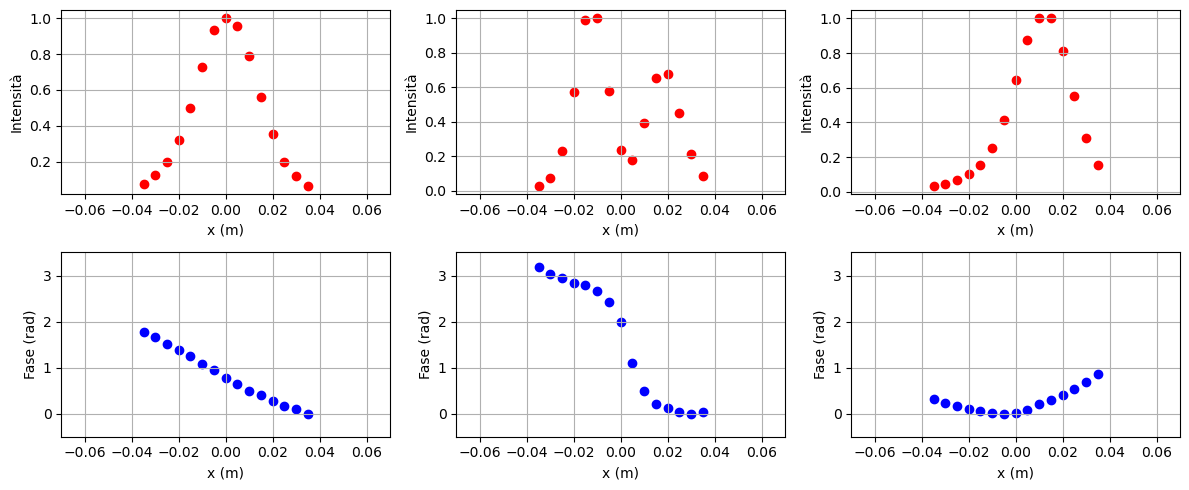

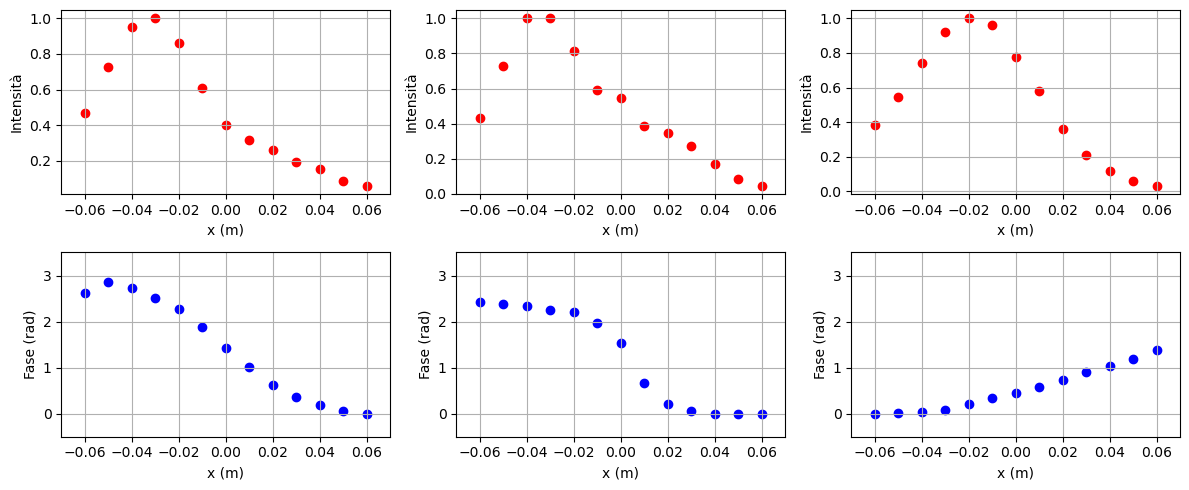

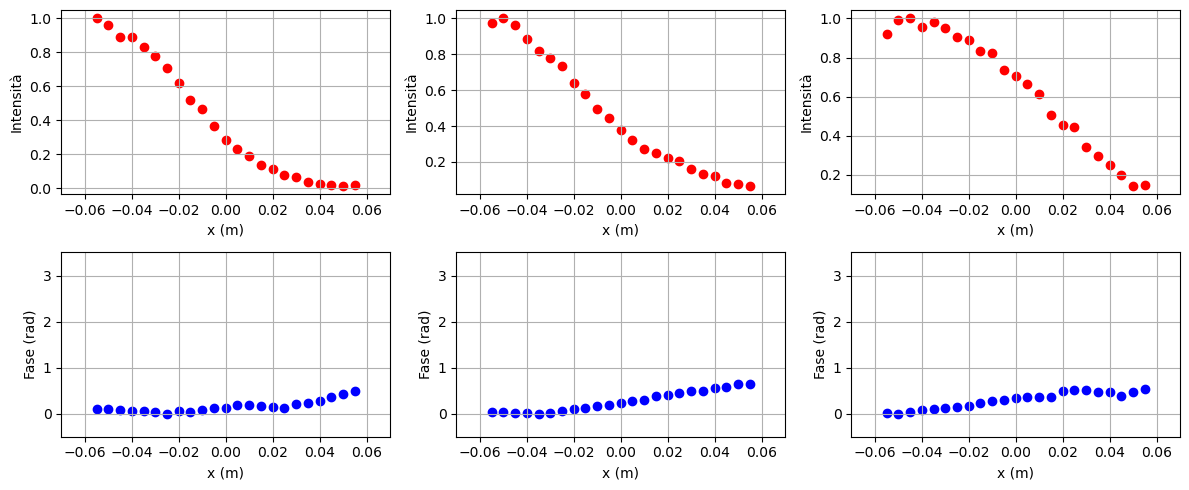

In [27]:
# Lettura e rappresentazione dati sperimentali
data = read_csv_data('data/0_4_0,5.csv', 'data/0_0_0,5.csv', 'data/0_-4_0,5.csv')
data2 = read_csv_data('data/0_4_4,5.csv', 'data/0_0_4,5.csv', 'data/0_-4_4,5.csv')
data3 = read_csv_data('data/0_4_10.csv', 'data/0_0_10.csv', 'data/0_-4_10.csv')
datas = [data, data2, data3]

plot_data_series(data, "near")
plot_data_series(data2, "mid")
plot_data_series(data3, "far")

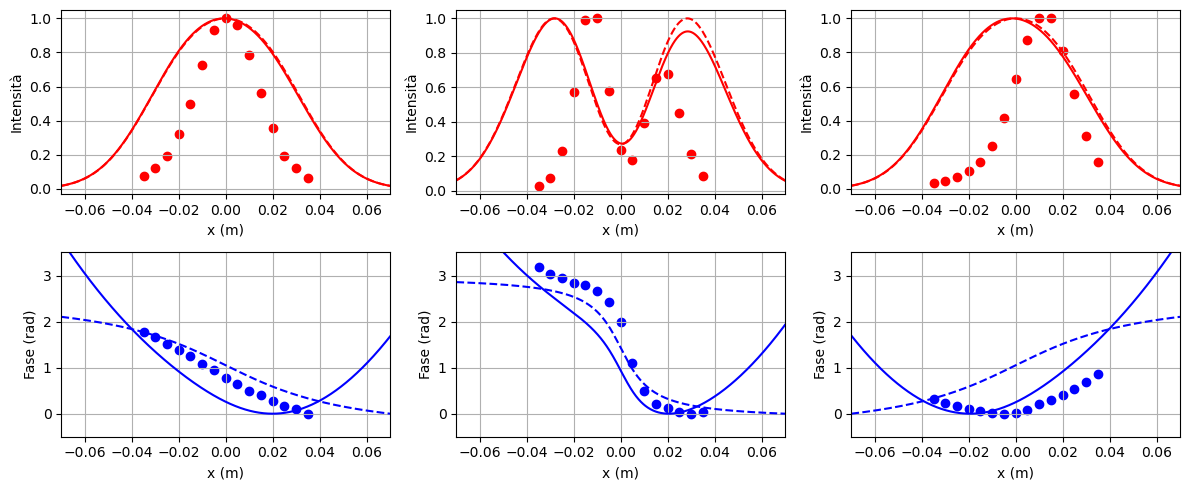

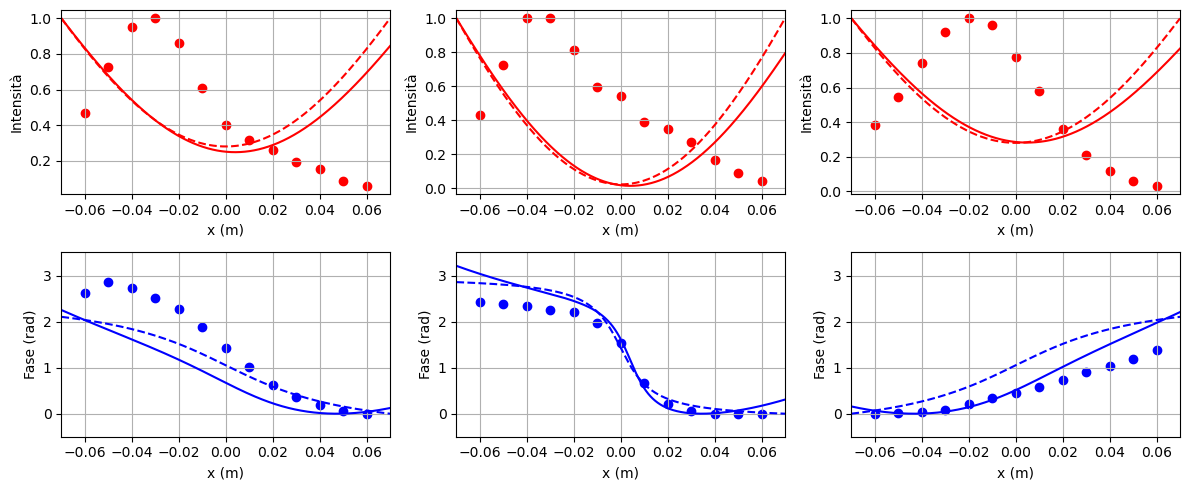

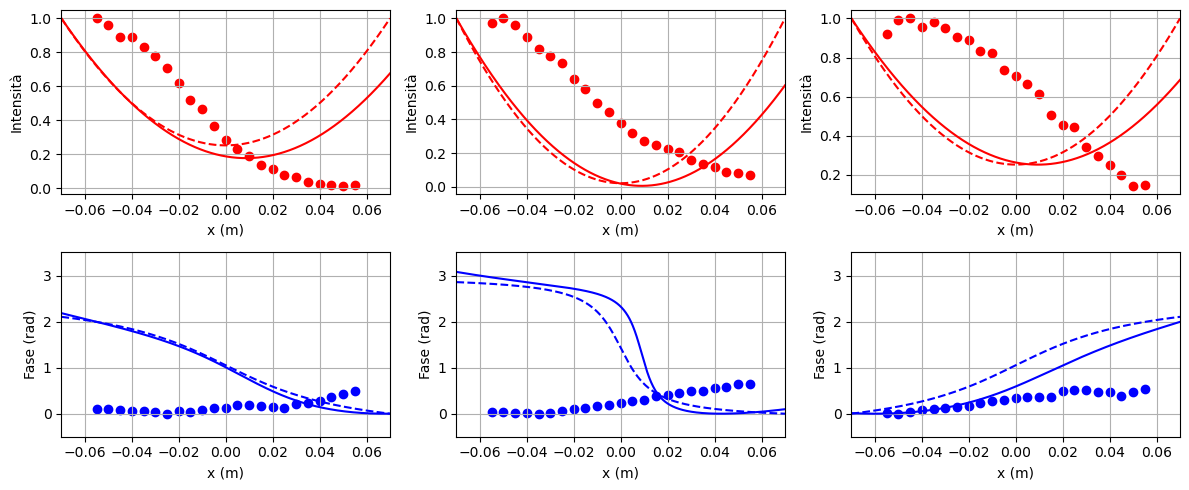

In [28]:
# Confronto diretto dati - modelli
for i, z0 in enumerate(z0_values):
	LG_exp = LG_meas(x=X, y=Y, z=z0, w0=0.03)
	LG_pur = LG_pl(x=X, y=Y, z=z0, w0=0.03, c=False)
	
	fig, axs = plt.subplots(2, 3, figsize=(12, 5))
	
	for idx, y0 in enumerate([0.04, 0.01, -0.04]):
		
		y_index = np.argmin(np.abs(Y[:, 0] - y0))
		LG_exp_y0 = LG_exp[y_index, :]
		LG_pur_y0 = LG_pur[y_index, :]

		plot_hor(LG_exp_y0, LG_pur_y0, [axs[0,idx],axs[1,idx]])
		axs[0, idx].scatter(datas[i][idx]['s'], datas[i][idx]['a'], color='red')
		axs[1, idx].scatter(datas[i][idx]['s'], datas[i][idx]['p'], color='blue')		

	plt.tight_layout()
	fig.savefig(f'images/comp_{z0}.png', format='png', dpi=300)
	plt.show()

In [29]:
# FUNZIONE FIT INTENSITA'
def predict_int(W, xf, yf, z0, wf):
	c=True
	if W == LG_pl:
		c=False
	values=np.abs(W(x=x, y=y, z=z0, w0=wf))**2
	mx=np.max(values)
	return np.abs(W(x=xf, y=yf, z=z0, w0=wf))**2/mx

# RESIDUI INTENSITA'
def residuals(params, W, data, z):
	X_fit, Y_fit, W_fit = params
	pos = data['s'].values
	inty = data['a'].values
	predicted_int = predict_int(W, pos + X_fit, Y_fit, z, W_fit)
	res = inty - predicted_int
	return res

# FIT
def dofit(W, init, data, z):    
	bounds = ([-0.01, init[1]-0.01, 0.03], [0.01, init[1]+0.01, 0.05])
	result = least_squares(residuals, init, args=(W, data, z), bounds=bounds)
	X_fit, Y_fit, W_fit= result.x
	fit = [X_fit, Y_fit, W_fit]
	return fit

# PLOT FIT INTENSITA'
def plotfit(init_list, data_list, z, name):
	fig, axs = plt.subplots(1, 3, figsize=(12, 4))
	
	linestyles = ['-', '--', ':']
	for j, W in enumerate([LG_meas, LG_sum, LG_pl]):
		for i in range(3):
			fit_params = dofit(W, init_list[i], data_list[i], z)
			c=True
			if W == LG_pl:
				c=False
			fitfunc_values = W(x + fit_params[0], fit_params[1], z, w0=fit_params[2], l=1, c=c)
			mx=np.max(np.abs(fitfunc_values)**2)

			axs[i].scatter(data_list[i]['s'], data_list[i]['a'], color='red')
			axs[i].plot(x, np.abs(fitfunc_values)**2/mx, color='red', linestyle=linestyles[j])
			axs[i].set_xlabel('x (m)')
			axs[i].set_ylabel('Fase (rad)')
			axs[i].grid(True)

	plt.tight_layout()
	plt.savefig(f'images/fitint_{name}.png', format='png', dpi=300)
	plt.show()

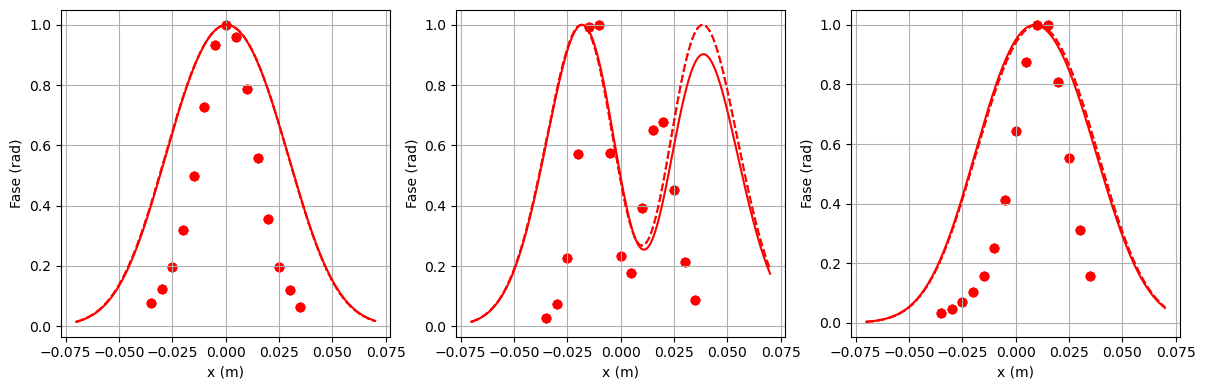

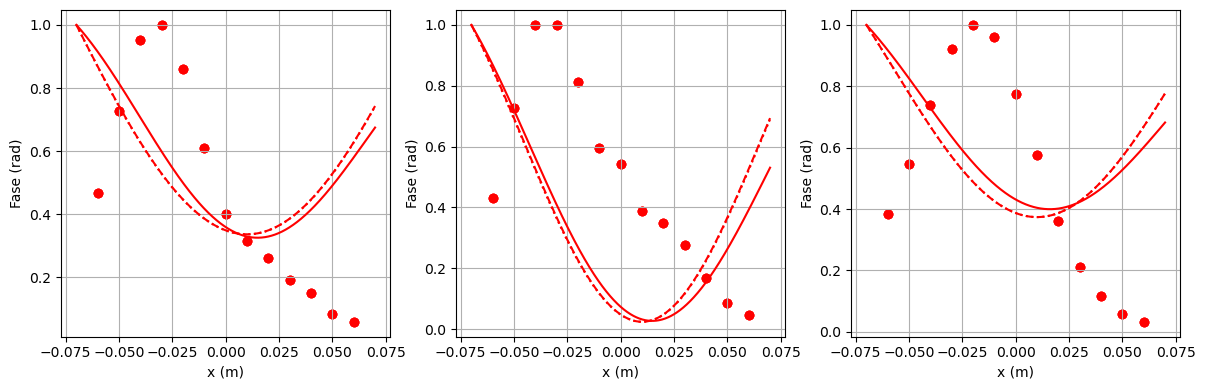

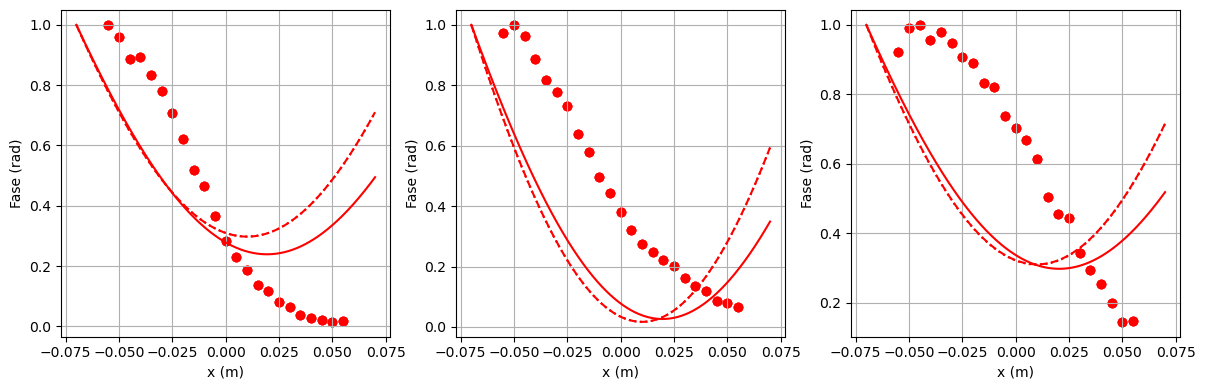

In [30]:
h = [0.04, 0, -0.04]
initial_guess = [[0, h[i], 0.04] for i in range(3)]
plotfit(initial_guess, data, 0.005, "near")
plotfit(initial_guess, data2, 0.045, "mid")
plotfit(initial_guess, data3, 0.1, "far")

In [31]:
# FUNZIONE FIT
def predict_ph(W, xf, yf, wf, z0):
	c=True
	if W == LG_pl:
		c=False
	values=np.unwrap(np.angle(W(x=x, y=y, z=z0, w0=wf, c=c)))
	mx=np.min(values)
	return np.unwrap(np.angle(W(x=xf, y=yf, z=z0, c=c)))-mx

# RESIDUI
def residuals(params, W, data, z):
	X_fit, Y_fit, W_fit = params
	pos = data['s'].values
	phase = data['p'].values
	predicted_ph = predict_ph(W, pos + X_fit, Y_fit, W_fit, z)
	res = phase - predicted_ph
	return res

# FIT
def dofit(W, init, data, z):    
	bounds = ([-0.01, init[1]-0.01, 0.03], [0.01, init[1]+0.01, 0.05])
	result = least_squares(residuals, init, args=(W, data, z), bounds=bounds)
	X_fit, Y_fit, W_fit = result.x
	fit = [X_fit, Y_fit, W_fit]
	return fit

# PLOT FIT
def plotfit(init_list, data_list, z, name):
	fig, axs = plt.subplots(1, 3, figsize=(12, 4))
	
	linestyles = ['-', '--', ':']
	for j, W in enumerate([LG_meas, LG_sum, LG_pl]):
		for i in range(3):
			fit_params = dofit(W, init_list[i], data_list[i], z)
			c=True
			if W == LG_pl:
				c=False
			fitfunc_values = np.unwrap(np.angle(W(x=x+fit_params[0], y=fit_params[1], z=z, w0=fit_params[2], l=1, c=c)))
			mx=np.min(fitfunc_values)
			
			axs[i].scatter(data_list[i]['s'], data_list[i]['p'], color='blue')
			axs[i].plot(x, fitfunc_values-mx, color='blue', linestyle=linestyles[j])
			axs[i].set_xlabel('x (m)')
			axs[i].set_ylabel('Fase (rad)')
			axs[i].set_ylim(-0.5, 3.5)
			axs[i].grid(True)

	plt.tight_layout()
	plt.savefig(f'images/fitph_{name}.png', format='png', dpi=300)
	plt.show()		

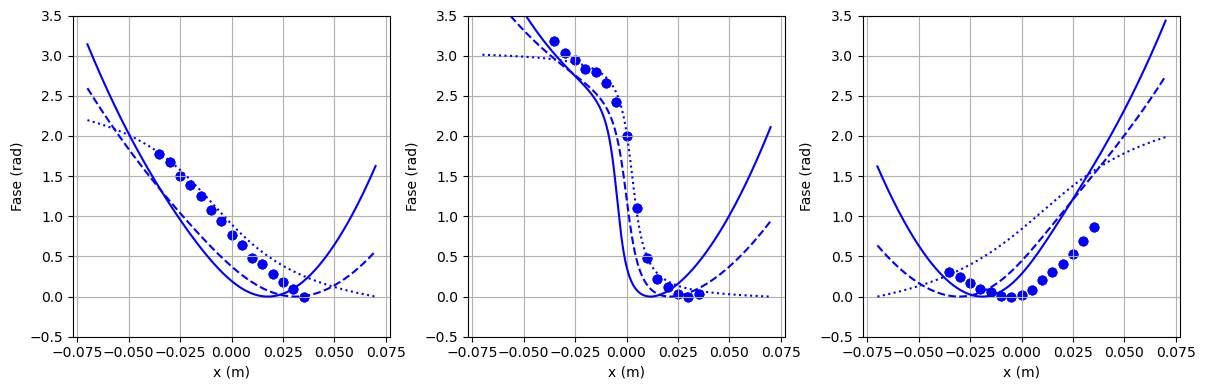

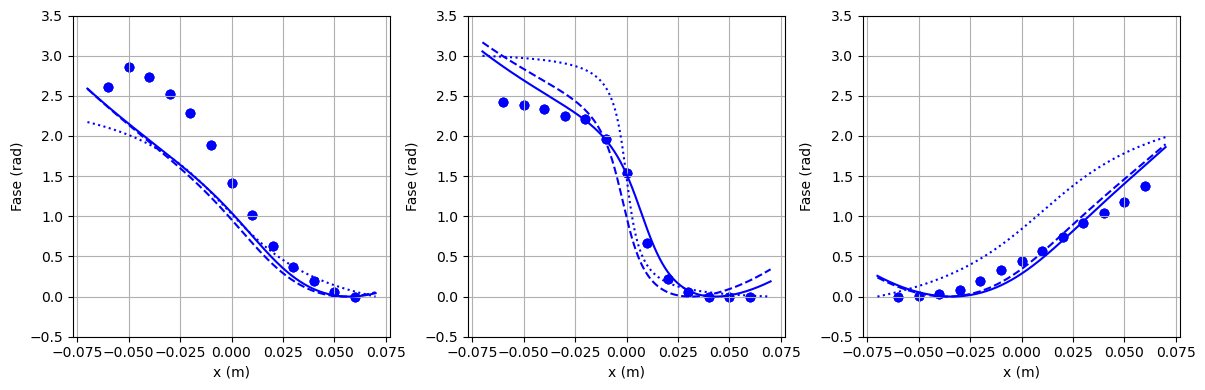

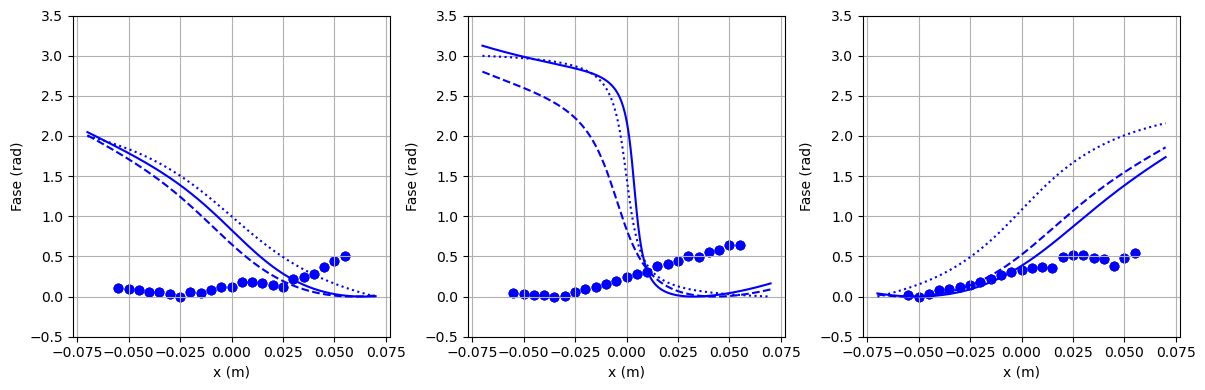

In [32]:
h = [0.04, 0, -0.04]
initial_guess = [[0, h[i]+0.005, 0.04] for i in range(3)]
plotfit(initial_guess, data, 0.005, "near")
plotfit(initial_guess, data2, 0.045, "mid")
plotfit(initial_guess, data3, 0.1, "far")

In [33]:
# FUNZIONE FIT
def predict_ph(W, xf, yf, wf, z0):
	values=np.unwrap(np.angle(W(x=x, y=y, z=z0, w0=wf, l=0)))
	mx=np.min(values)
	return np.unwrap(np.angle(W(x=xf, y=yf, z=z0, l=0)))-mx

# RESIDUI
def residuals(params, W, data, z):
	X_fit, Y_fit, W_fit = params
	pos = data['s'].values
	phase = data['p'].values
	predicted_ph = predict_ph(W, pos + X_fit, Y_fit, W_fit, z)
	res = phase - predicted_ph
	return res

# FIT
def dofit(W, init, data, z):    
	bounds = ([-0.01, init[1]-0.01, 0.01], [0.01, init[1]+0.01, 0.06])
	result = least_squares(residuals, init, args=(W, data, z), bounds=bounds)
	X_fit, Y_fit, W_fit = result.x
	fit = [X_fit, Y_fit, W_fit]
	return fit

# PLOT FIT
def plotfit(init_list, data_list, z, name):
	fig, axs = plt.subplots(1, 3, figsize=(12, 4))
	
	linestyles = ['-', '--', ':']
	for j, W in enumerate([LG_meas, LG_sum, LG_pl]):
		for i in range(3):
			fit_params = dofit(W, init_list[i], data_list[i], z)
			fitfunc_values = np.unwrap(np.angle(W(x=x+fit_params[0], y=fit_params[1], z=z, w0=fit_params[2], l=0)))
			mx=np.min(fitfunc_values)
			
			axs[i].scatter(data_list[i]['s'], data_list[i]['p'], color='blue')
			axs[i].plot(x, fitfunc_values-mx, color='blue', linestyle=linestyles[j])
			axs[i].set_xlabel('x (m)')
			axs[i].set_ylabel('Fase (rad)')
			axs[i].set_ylim(-1, 1)
			axs[i].grid(True)

	plt.tight_layout()
	plt.savefig(f'images/fitgauss_{name}.png', format='png', dpi=300)
	plt.show()	

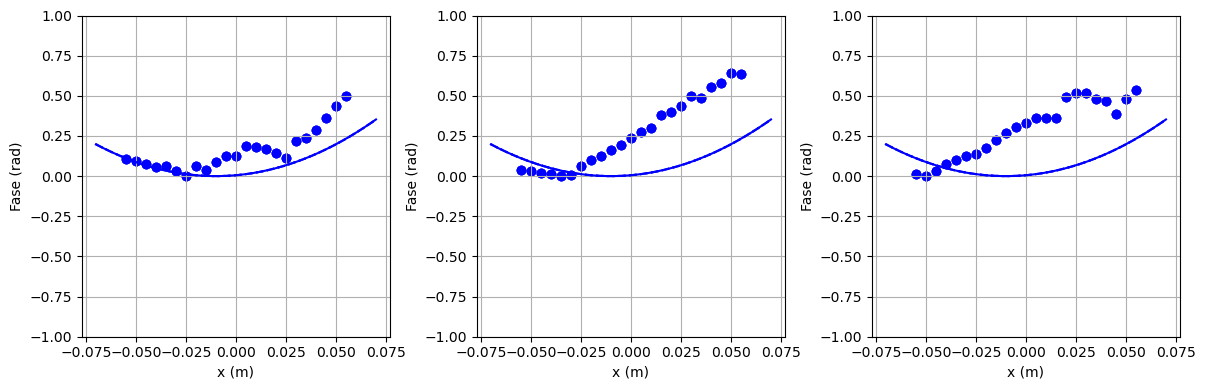

In [34]:
h = [0.04, 0, -0.04]
initial_guess = [[0, h[i], 0.02] for i in range(3)]
plotfit(initial_guess, data3, 0.1, "far2")

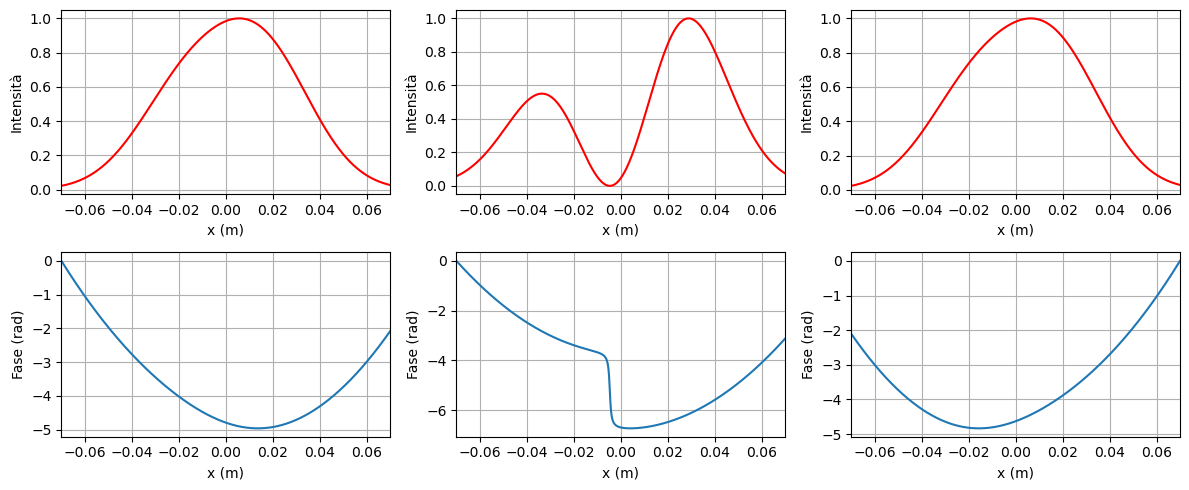

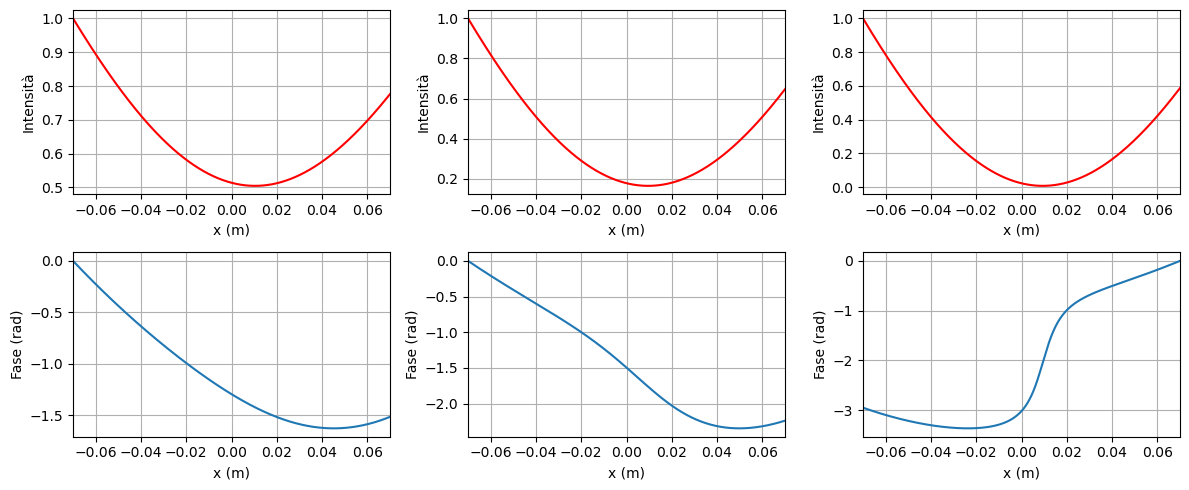

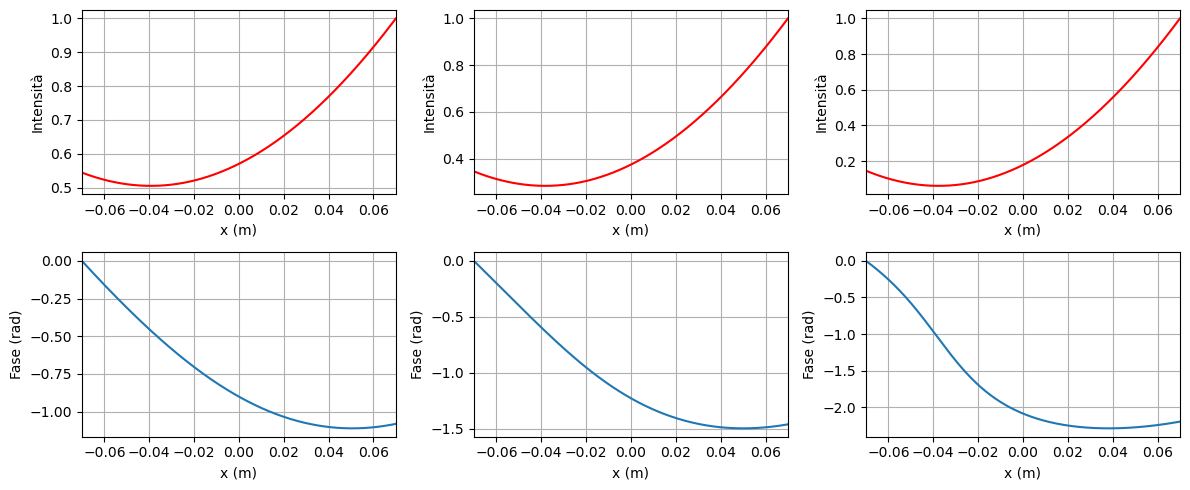

In [35]:
# SIMULAZIONI ORIZZONTALI IPOTESI RUMORE DI FONDO
for z0 in [0.005, 0.045, 0.1]:
	LG_exp = LG_pl(X, Y, z0, w0=0.025, l=1) + 0.15*LG_pl(X,Y,z0, w0=0.025,l=0)

	fig, axs = plt.subplots(2, 3, figsize=(12, 5))
	
	for idx, y0 in enumerate([0.04, 0, -0.04]):
		
		y_index = np.argmin(np.abs(Y[:, 0] - y0))
		LG_y0 = LG_exp[y_index, :]
		N = (np.abs(LG_y0)).max()**2
		O = (np.unwrap(np.angle(LG_y0))).max()
		
		axs[0, idx].plot(X[0, :], (np.abs(LG_y0)**2)/N, color='red')
		axs[0, idx].set_xlabel('x (m)')
		axs[0, idx].set_xlim(-a, a)
		axs[0, idx].set_ylabel('Intensità')
		axs[0, idx].grid(True)

		axs[1, idx].plot(X[0, :], (np.unwrap(np.angle(LG_y0))-O))
		axs[1, idx].set_xlabel('x (m)')
		axs[1, idx].set_xlim(-a, a)
		axs[1, idx].set_ylabel('Fase (rad)')
		axs[1, idx].grid(True)
	
	plt.tight_layout()
	fig.savefig(f'images/LG_{z0}horsup.png', format='png', dpi=300)
	plt.show()

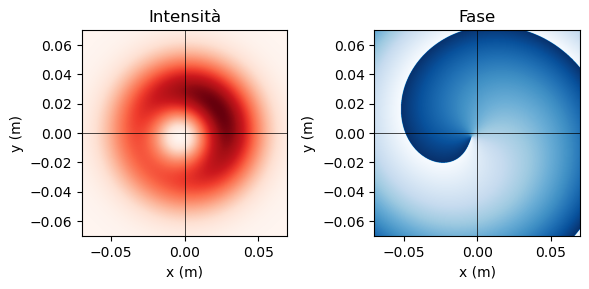

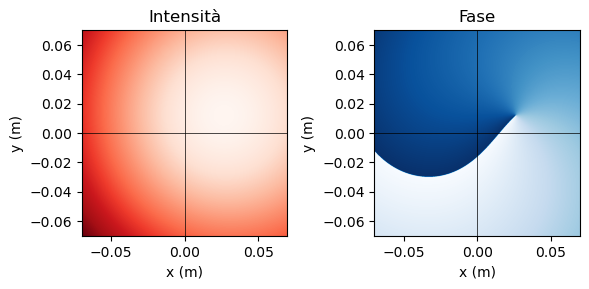

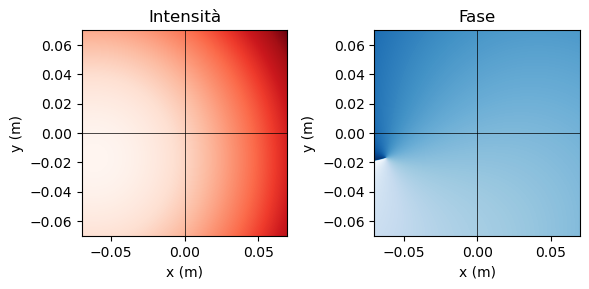

In [36]:
for z0 in [0.005, 0.045, 0.1]:
	LG_exp = LG_pl(X, Y, z0, w0=0.03, l=1) + 0.15*LG_pl(X,Y,z0, w0=0.03,l=0)
	
	duo_plot(LG_exp, f'noise_{z0}.png')

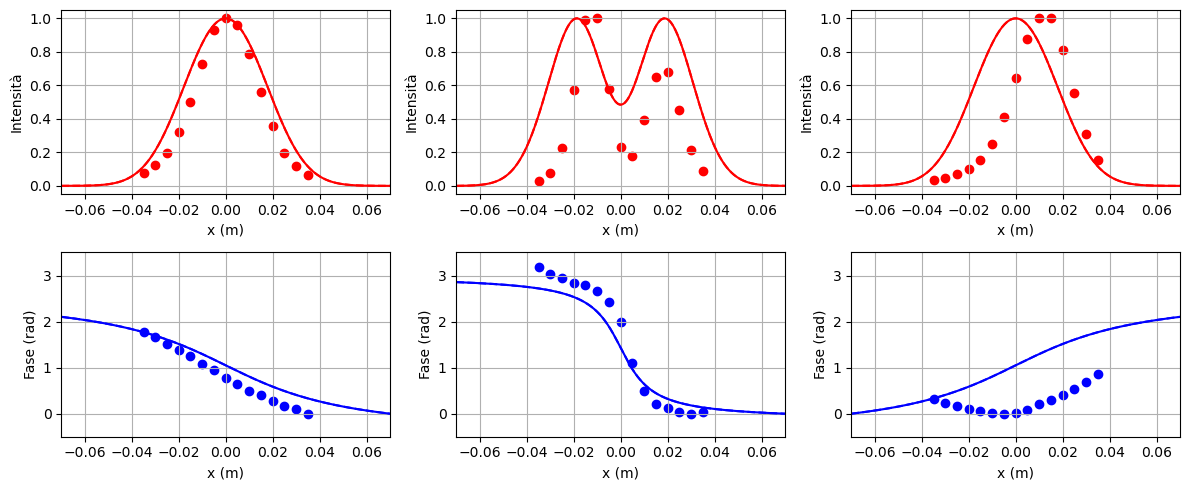

In [37]:
# Spostamento del waist
i=0
z0=0.005

LG_exp = LG_pl(x=X, y=Y, z=0.000001, w0=0.03)
LG_pur = LG_exp

fig, axs = plt.subplots(2, 3, figsize=(12, 5))

for idx, y0 in enumerate([0.04, 0.01, -0.04]):

	y_index = np.argmin(np.abs(Y[:, 0] - y0))
	LG_exp_y0 = LG_exp[y_index, :]
	LG_pur_y0 = LG_pur[y_index, :]

	plot_hor(LG_exp_y0, LG_pur_y0, [axs[0,idx],axs[1,idx]])
	axs[0, idx].scatter(datas[i][idx]['s'], datas[i][idx]['a'], color='red')
	axs[1, idx].scatter(datas[i][idx]['s'], datas[i][idx]['p'], color='blue')	

plt.tight_layout()
fig.savefig(f'images/comp_foc{z0}.png', format='png', dpi=300)
plt.show()

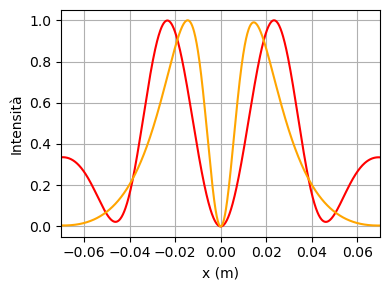

In [38]:
def rotate_coordinates(x, y, z, theta, phi):
    # gradi in radianti
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)
    
    # Rotazione attorno y di theta (azimuthale)
    x_new = x * np.cos(theta) + z * np.sin(theta)
    z_new = -x * np.sin(theta) + z * np.cos(theta)
    
    # Rotazione attorno x_new di phi (polare)
    y_new = y * np.cos(phi) - z_new * np.sin(phi)
    z_new = y * np.sin(phi) + z_new * np.cos(phi)
    
    return x_new, y_new, z_new

def LG_pl(x, y, z, A=1, w0=0.01, lam=0.57, p=0, l=1, ph=0, c=True, theta=0, phi=0):
    x, y, z = rotate_coordinates(x, y, z, theta, phi)
    
    r = np.hypot(x, y)
    theta = np.arctan2(y, x)
    
    k = 2 * np.pi / lam
    zr = np.pi * w0**2 / lam
    w = w0 * np.sqrt(1 + (z / zr)**2)
    L_p_l = genlaguerre(p, np.abs(l))(2 * r**2 / w**2)
    
    norm = A * np.sqrt((2 * math.factorial(p)) / (np.pi * w**2 * math.factorial(p + np.abs(l)))) * (r * np.sqrt(2) / w)**np.abs(l)
    gauss = np.exp(-r**2 / w**2)
    lag = L_p_l * np.exp(1j * l * theta)
    curv = np.exp(1j * k * r**2 * z / 2 / (z**2 + zr**2))
    if not c:
        curv = 1
    guoy = np.exp(-1j * (2 * p + np.abs(l) + 1) * np.arctan(z / zr))
    arb = np.exp(1j * ph)
    
    return norm * gauss * lag * curv * guoy * arb

def LG_sum(x=X, y=Y, z=z0, A=1, A_err=0, w0=0.03, lam=0.57, p=0, l=1, ph=0, phi_err=0, d=0.013, h=0.005, c=True):
	angles = np.linspace(0 + np.pi / 4 + ph, 2 * np.pi + np.pi / 4 + ph, 4, endpoint=False)
	vert = [(d * np.cos(angle), d * np.sin(angle)) for angle in angles]

	a=h
	theta_inclination = [-a, a, a, -a]
	phi_inclination = [a, a, -a, -a]

	LG = np.zeros_like(x, dtype=complex)
	for i in range(4):
		A_mod = A * random.uniform(1 - A_err / 2, 1 + A_err / 2)
		phi_mod = ph + i * l * np.pi / 2 * random.uniform(np.sqrt(1 - phi_err / 2), np.sqrt(1 + phi_err / 2))

		LG += LG_pl(x + vert[i][0], y + vert[i][1], z=z, A=A_mod, w0=w0, lam=lam, p=p, l=0, ph=phi_mod, c=c, theta=theta_inclination[i], phi=phi_inclination[i])

	return LG


fig, ax = plt.subplots(1, 1, figsize=(4, 3))
for h in [2*np.pi, -0-5*np.pi]:
	LG = LG_sum(z=0.005, l=1, h=h)
#	duo_plot(LG, 'test')

	y0=0
	y_index = np.argmin(np.abs(Y[:, 0] - y0))
	LG_exp_y0 = np.abs(LG[y_index, :])**2
	LG_exp_y0 /= LG_exp_y0.max()
	
	if h != 2*np.pi:
		ax.plot(X[0, :], LG_exp_y0, color='orange')
	else:
		ax.plot(X[0, :], LG_exp_y0, color='red')
	a=0.2
	ax.set_xlabel('x (m)')
	ax.set_xlim(-0.07, 0.07)
	ax.set_ylabel('Intensità')
	ax.grid(True)

plt.tight_layout()
fig.savefig(f'images/tilt.png', format='png', dpi=300)
plt.show()